<a href="https://colab.research.google.com/github/liron7722/AI-Generated-Text-Detector/blob/Production/ai_generated_text_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TO-DO




Done:
GH Proejct created
Getting larger Dataset
EDA Start

Not to
- do lower case manipulation on the text


Next Steps

* Do comperistion between Generated and not Generated Words\Sentences count  
* Balance the data by multiple smaller class by 3
* Feaures
* Use n-grams - Combination of group of words

Optional (Future)
- make graph of our etl or models
- Consider dataset


## Deck Remarks

Inital Deck remarks


מספרי כרטסיטיות

גופן

יותר מידי זמן על הרקע

יותר הסברים על הפיצרים

לא להתרכז ב f1

להגדיל כתב ולנצל שטח פתוח

להסביר על הטיפול באיזון של המידע

שיהיה קוד שנהיה גאים בו ונפגין יכולות

עמוד פתיחה עם תמונה רלוונטית

בהצגה סופית להסביר טכני

להראות דוגמא של טקסט ממכונה והלראות שזה לא פשוט לנחש

שיהיה בשר תכנותי, לשקול לכתוב מודל משלנו



דברים שעושים במצגות ברמה גבוהה
מוסיפים איזה אייקון לכל שקופית מספר פעמים ומבקשים מהקהל להגיד כמה היה בסוף המצגת


לפני ששואלים שאלה אותנו אז נבקש להגיד מילת מפתח כמו השם של הקבוצה שלנו או משהו מהותי למצגת שלנו
בסוף כל המצגות נראה שאמרו את המיל מפתח שלנו הכי הרבה
בגרף של המילים


לשאול את הכיתה בהתחלה כמה מהמצגת שלנו נוצרה ע"י LLM








###### KaggleCompetition

In [ ]:
# KaggleCompetition = 'https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview'



```
File and Field Information

{test|train}_essays.csv
id - A unique identifier for each essay.
prompt_id - Identifies the p\rompt the essay was written in response to.
text - The essay text itself.
generated - Whether the essay was written by a student (0) or generated by an LLM (1).
This field is the target and is not present in test_essays.csv.

train_prompts.csv - Essays were written in response to information in these fields.
prompt_id - A unique identifier for each prompt.
prompt_name - The title of the prompt.
instructions - The instructions given to students.
source_text - The text of the article(s) the essays were written in response to, in Markdown format.
Significant paragraphs are enumerated by a numeral preceding the paragraph on the same line, as in 0 Paragraph one.
Paragraph two.. Essays sometimes refer to a paragraph by its numeral.
Each article is preceded with its title in a heading, like # Title.
When an author is indicated, their name will be given in the title after by.
Not all articles have authors indicated. An article may have subheadings indicated like ## Subheading.

sample_submission.csv - A submission file in the correct format. See the Evaluation page for details.
```



## CFG
class for variables

In [ ]:
class CFG:
  verbose = 0  # Verbosity

  wandb = True  # Weights & Biases logging
  competition = 'llm-detect-ai-generated-text'  # Competition name
  _wandb_kernel = 'awsaf49'  # WandB kernel
  comment = 'DebertaV3-MaxSeq_200-ext_s-torch'  # Comment description

  preset = "deberta_v3_base_en"  # Name of pretrained models
  sequence_length = 200  # Input sequence length

  device = 'TPU'  # Device

  seed = 42  # Random seed

  num_folds = 5  # Total folds
  selected_folds = [0, 1]  # Folds to train on

  epochs = 3 # Training epochs
  batch_size = 3  # Batch size
  drop_remainder = True  # Drop incomplete batches
  cache = True # Caches data after one iteration, use only with `TPU` to avoid OOM

  scheduler = 'cosine'  # Learning rate scheduler

  class_names = ["real", "fake"]  # Class names [A, B, C, D, E]
  num_classes = len(class_names)  # Number of classes
  class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
  label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
  name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import io
import sys
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import string
import re
import nltk

import pyarrow as pa

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
#from nltk.util import ngram_freq
from nltk.translate import nist_score
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

cmap = mpl.colormaps.get_cmap('coolwarm')

In [ ]:
train_essays = pd.read_csv('https://raw.githubusercontent.com/liron7722/AI-Generated-Text-Detector/refs/heads/Production/data/train_essays.csv')
train_prompts = pd.read_csv('https://raw.githubusercontent.com/liron7722/AI-Generated-Text-Detector/refs/heads/Production/data/train_prompts.csv')
train_essays.head()

,version https://git-lfs.github.com/spec/v1
0,oid sha256:9c69738ab129c335ef8b0a5ac14330fcfc5...
1,size 4399547


In [ ]:
import warnings
warnings.filterwarnings('ignore')
for pkg in ['omw-1.4', 'punkt', 'punkt_tab', 'averaged_perceptron_tagger', 'stopwords', 'averaged_perceptron_tagger_eng']:
  nltk.download(pkg, quiet=True)

## Loading Data

In [ ]:
text_df = pd.read_parquet('https://github.com/liron7722/AI-Generated-Text-Detector/raw/refs/heads/Production/data/train_essays.parquet')
text_df

,id,prompt_id,text,generated
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1
...,...,...,...,...
165762,e_163n6u2y,103,We were meant to do this together. That was th...,0
165763,e_a8z8z5hc,103,Title: Emerald Smoke\nWord Count: 701\nThe onc...,1
165764,e_qltzexs2,103,"In a sleepy town nestled amidst rolling hills,...",1
165765,e_n1p85skh,103,"In the bustling city of Elysium, nestled amids...",1


In [ ]:
text_df['text'][165763]

"Title: Emerald Smoke\nWord Count: 701\nThe once-thriving city lay in ruins, a chaotic mix of crumbling buildings and debris strewn across the streets. The air was heavy with smoke, a constant reminder of the devastation that had befallen humanity. Amidst the chaos, a small group of soldiers trudged through the desolate landscape, their uniforms tattered and faces etched with exhaustion.\nSergeant Jameson, the group leader, led them with a grim determination. His squad consisted of Private Reynolds, Corporal Jensen, and Specialist Taylor, each silently contemplating the horrors they had witnessed. They had grown used to the distorted world they found themselves in, where scarcity defined survival, and fear gripped every waking moment.\nIt was during one of their routine patrols that Jensen noticed something glimmering near a collapsed building. Intrigued, he urged his comrades towards it. Beneath the rubble, they discovered a partially intact box, its contents unscathed by time. The so

In [ ]:
text_df['generated'].value_counts()

,count
generated,
1,129522
0,36245


In [ ]:
text_df[['prompt_id','generated']].value_counts().sort_index()

prompt_id  generated
0          0             3320
           1            10525
1          0             3232
           1            10629
2          0             2132
           1            10542
3          0             1974
           1             9828
4          0             2319
           1            11162
5          0             2657
           1            11190
6          0             2324
           1            11524
7          0             2534
           1             5850
8          0             1895
           1             5663
9          0             1969
           1             5190
10         0             1976
           1             6498
11         0             1940
           1             5713
12         0             1860
           1             6165
13         0             1804
           1             5437
14         0             1353
           1             4484
100        0              970
           1             3095
102        0              975
           1             2971
103        0             1011
           1             3056
Name: count, dtype: int64

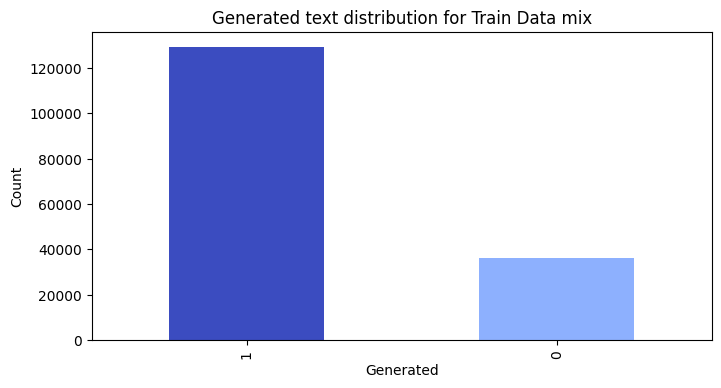

In [ ]:
# Show distribution of generated text using a bar plot
plt.figure(figsize=(8, 4))
text_df.generated.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Generated")
plt.ylabel("Count")
plt.title("Generated text distribution for Train Data mix")
plt.show()

## Removing Duplicate Rows

In [ ]:
# Removing Duplicate Rows
text_df = text_df.drop_duplicates(subset=['text'])
text_df.reset_index(drop=True, inplace=True)

In [ ]:
# chech for missing data
text_df.isnull().sum()
#text_df.count()

,0
id,0
prompt_id,0
text,0
generated,0


## Counts and Lenght:
### Start by checking how long the reviews are



*   Character count
*   Word count
*   Mean word length
*   Mean sentence length

In [ ]:
lenght = len(text_df['text'][0])
print(f'Length of a sample assay: {lenght}')

Length of a sample assay: 1789


In [ ]:
text_df['Length'] = text_df['text'].str.len()
text_df.head(10)

,id,prompt_id,text,generated,Length
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592
5,e_mgv97k7z,0,Limiting car usage will have many advantages. ...,0,2049
6,e_3zjz1v5b,0,### The Advantages of Limiting Car Usage\n\nCa...,1,3615
7,e_1m6o7oy4,0,"Cars have been around since the early 1900's, ...",0,2971
8,e_cl5fygab,0,Cars have been an important part of our societ...,1,2203
9,e_d3pyqm0y,0,Think about a country without cars. You might ...,1,2437


In [ ]:
#Word Count: Number of words in a assay
word_count = text_df['text'][0].split()
print(f'Word count in a sample assay: {len(word_count)}')

Word count in a sample assay: 316


In [ ]:
def word_count(text):
    text_list = text.split()
    return len(text_list)

In [ ]:
text_df['Word_count'] = text_df['text'].apply(word_count)
text_df.head(10)

,id,prompt_id,text,generated,Length,Word_count
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314
5,e_mgv97k7z,0,Limiting car usage will have many advantages. ...,0,2049,364
6,e_3zjz1v5b,0,### The Advantages of Limiting Car Usage\n\nCa...,1,3615,614
7,e_1m6o7oy4,0,"Cars have been around since the early 1900's, ...",0,2971,515
8,e_cl5fygab,0,Cars have been an important part of our societ...,1,2203,410
9,e_d3pyqm0y,0,Think about a country without cars. You might ...,1,2437,449


In [ ]:
# Mean word length: Average length of words
text_df['mean_word_length'] = text_df['text'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
#text_df['total_word_length'] = text_df['text'].map(lambda rev: np.sum([len(word) for word in rev.split()]))
text_df.head(10)

,id,prompt_id,text,generated,Length,Word_count,mean_word_length
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316,4.648734
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596,4.870805
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392,4.647959
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308,4.025974
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314,4.063694
5,e_mgv97k7z,0,Limiting car usage will have many advantages. ...,0,2049,364,4.620879
6,e_3zjz1v5b,0,### The Advantages of Limiting Car Usage\n\nCa...,1,3615,614,4.858306
7,e_1m6o7oy4,0,"Cars have been around since the early 1900's, ...",0,2971,515,4.763107
8,e_cl5fygab,0,Cars have been an important part of our societ...,1,2203,410,4.365854
9,e_d3pyqm0y,0,Think about a country without cars. You might ...,1,2437,449,4.418708


In [ ]:
# Mean sentence length: Average length of the sentences in the review, split by dot
text_df['mean_sentence_length_split'] = text_df['text'].map(lambda rev: np.mean([len(sent) for sent in rev.split('.')]))
#text_df['total_sentence_length_split'] = text_df['text'].map(lambda rev: np.sum([len(sent) for sent in rev.split('.')]))
text_df.head(10)

,id,prompt_id,text,generated,Length,Word_count,mean_word_length,mean_sentence_length_split
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316,4.648734,84.238095
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596,4.870805,174.000000
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392,4.647959,169.461538
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308,4.025974,61.160000
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314,4.063694,98.562500
5,e_mgv97k7z,0,Limiting car usage will have many advantages. ...,0,2049,364,4.620879,77.846154
6,e_3zjz1v5b,0,### The Advantages of Limiting Car Usage\n\nCa...,1,3615,614,4.858306,96.729730
7,e_1m6o7oy4,0,"Cars have been around since the early 1900's, ...",0,2971,515,4.763107,101.482759
8,e_cl5fygab,0,Cars have been an important part of our societ...,1,2203,410,4.365854,75.000000
9,e_d3pyqm0y,0,Think about a country without cars. You might ...,1,2437,449,4.418708,115.095238


In [ ]:
# Mean sentence length: Average length of the sentences in the review, split by tokenize
tmp = pd.DataFrame()
tmp['tokens'] = text_df['text'].map(lambda rev: [len(sent) for sent in tokenize.sent_tokenize(rev)])
#tmp.head(10)

In [ ]:
text_df['mean_sentence_length_tokenize'] = tmp['tokens'].map(lambda rev: np.mean(rev))
#text_df['total_sentence_length_tokenize'] = tmp['tokens'].map(lambda rev: np.sum(rev))
text_df.head()

,id,prompt_id,text,generated,Length,Word_count,mean_word_length,mean_sentence_length_split,mean_sentence_length_tokenize
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316,4.648734,84.238095,88.250000
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596,4.870805,174.000000,183.157895
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392,4.647959,169.461538,276.000000
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308,4.025974,61.160000,60.960000
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314,4.063694,98.562500,92.529412


In [ ]:
from nltk.util import ngrams
from collections import Counter

In [ ]:
text = text_df['text'].values[0]  # Assuming 'text' column contains a single string per row.
# ngram_counts = nltk.collocations(text, n=2)  # Calculate frequency of bigrams (2-grams)
text

"In recent years, there has been a growing movement to limit car usage. This is due to a number of factors, including the increasing cost of owning a car, the environmental impact of car emissions, and the growing popularity of alternative forms of transportation, such as walking, biking, and public transit.\n\nThere are many benefits to limiting car usage. For one, it can save you money. The average car payment in the United States is over $500 per month, and that doesn't include the cost of gas, insurance, and maintenance. If you can get by without a car, you can save a significant amount of money each month.\n\nLimiting car usage can also help the environment. Cars are a major source of air pollution, and they contribute to climate change. By choosing to walk, bike, or take public transit instead of driving, you can reduce your impact on the environment.\n\nFinally, limiting car usage can make your life more enjoyable. When you don't have to worry about driving, you have more time t

In [ ]:
tokens = nltk.word_tokenize(text)

# Generate bigrams, trigrams, and quadragrams
bigrams = list(ngrams(tokens, 2))
trigrams = list(ngrams(tokens, 3))
quadragrams = list(ngrams(tokens, 4))

# Count frequencies of each n-gram
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)
quadragram_freq = Counter(quadragrams)

# Display results
print("Bigrams:", bigram_freq)
print("Trigrams:", trigram_freq)
print("Quadragrams:", quadragram_freq)

Bigrams: Counter({('car', 'usage'): 6, (',', 'and'): 6, ('public', 'transit'): 4, ('you', 'can'): 4, (',', 'there'): 3, ('a', 'car'): 3, ('.', 'If'): 3, ('If', 'you'): 3, (',', 'you'): 3, ('usage', 'can'): 3, ('the', 'environment'): 3, ('are', 'a'): 3, ('usage', '.'): 2, ('.', 'This'): 2, ('a', 'number'): 2, ('number', 'of'): 2, ('cost', 'of'): 2, ('car', ','): 2, ('limiting', 'car'): 2, ('can', 'save'): 2, ('without', 'a'): 2, ('.', 'Limiting'): 2, ('Limiting', 'car'): 2, ('can', 'also'): 2, ('help', 'the'): 2, ('environment', '.'): 2, ('driving', ','): 2, ('you', "'re"): 2, ("'re", 'thinking'): 2, ('thinking', 'about'): 2, ('there', 'are'): 2, ('in', 'a'): 2, ('In', 'recent'): 1, ('recent', 'years'): 1, ('years', ','): 1, ('there', 'has'): 1, ('has', 'been'): 1, ('been', 'a'): 1, ('a', 'growing'): 1, ('growing', 'movement'): 1, ('movement', 'to'): 1, ('to', 'limit'): 1, ('limit', 'car'): 1, ('This', 'is'): 1, ('is', 'due'): 1, ('due', 'to'): 1, ('to', 'a'): 1, ('of', 'factors'): 1, (

Text Complexity Features

	•	Unique Word Count: The number of unique words in each text sample, capturing vocabulary richness.
	•	Stop Word Count: The number of common stop words (like “the”, “is”, “and”) that can indicate writing style.
	•	Readability Scores: Metrics like Flesch-Kincaid or Gunning Fog scores, which can give insights into text complexity.

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

text_df['unique_word_count'] = text_df['text'].apply(lambda x: len(set(x.split())))
text_df['stopword_count'] = text_df['text'].apply(lambda x: len([word for word in x.split() if word in stop_words]))

TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF is a way to weigh words based on how frequently they appear across documents, emphasizing unique words. This is often more effective than raw word counts for feature extraction.

In [ ]:
# Takes time
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  # Unigrams and bigrams
# tfidf_features = tfidf.fit_transform(text_df['text'])

Sentiment Analysis

Many libraries, like TextBlob or VADER, provide sentiment analysis, yielding features like polarity (positive/negative sentiment) and subjectivity.

In [ ]:
from textblob import TextBlob

text_df['polarity'] = text_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df['subjectivity'] = text_df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

Part-of-Speech (POS) Tagging

POS tagging can help identify patterns in language use, such as the frequency of nouns, verbs, or adjectives. This is useful for certain NLP tasks like author profiling or style analysis.

In [ ]:
def pos_counts(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    pos_counts = nltk.FreqDist(tag for _, tag in pos_tags)
    return pos_counts

text_df['pos_counts'] = text_df['text'].apply(pos_counts)

Named Entity Recognition (NER)

NER identifies entities like people, places, and organizations, which can be informative for text classification. The spaCy library provides easy-to-use NER.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

text_df['entities'] = text_df['text'].apply(extract_entities)

Word Embeddings (e.g., Word2Vec, GloVe)

Pre-trained word embeddings capture semantic meaning. Averaging word embeddings in a sentence or using pooled embeddings (like BERT) can create dense, informative features.

In [ ]:
# Example using Word2Vec (use GloVe or FastText similarly)
from gensim.models import Word2Vec

# Tokenize text data
sentences = text_df['text'].apply(lambda x: x.split())
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)

# Generate embedding for each document by averaging word embeddings
def average_embedding(text):
    words = text.split()
    return sum(w2v_model.wv[word] for word in words if word in w2v_model.wv) / len(words)

text_df['avg_word2vec'] = text_df['text'].apply(average_embedding)

Topic Modeling (LDA or NMF)

Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF) can identify topics in text, converting documents into a fixed number of topics.

In [ ]:
# 15m+
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)
dtm = vectorizer.fit_transform(text_df['text'])

lda = LatentDirichletAllocation(n_components=5)
topic_matrix = lda.fit_transform(dtm)

In [ ]:
print(topic_matrix)

Bag-of-Words (BOW)

BOW is a basic yet powerful representation of text as sparse vectors. You can limit the vocabulary size to manage feature count, as shown previously.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(max_features=1000, ngram_range=(1, 2))
bow_features = bow.fit_transform(text_df['text'])

In [ ]:
print(bow_features)

  (0, 393)	5
  (0, 983)	1
  (0, 814)	4
  (0, 349)	1
  (0, 108)	1
  (0, 856)	13
  (0, 143)	11
  (0, 905)	6
  (0, 842)	2
  (0, 411)	3
  (0, 239)	1
  (0, 534)	2
  (0, 536)	13
  (0, 404)	1
  (0, 770)	11
  (0, 389)	2
  (0, 253)	1
  (0, 43)	9
  (0, 886)	1
  (0, 731)	1
  (0, 73)	1
  (0, 627)	4
  (0, 62)	5
  (0, 490)	2
  (0, 116)	1
  :	:
  (158293, 175)	1
  (158293, 783)	3
  (158293, 128)	1
  (158293, 938)	1
  (158293, 406)	1
  (158293, 589)	2
  (158293, 110)	2
  (158293, 615)	1
  (158293, 614)	1
  (158293, 184)	1
  (158293, 984)	1
  (158293, 809)	1
  (158293, 410)	1
  (158293, 402)	1
  (158293, 117)	1
  (158293, 80)	1
  (158293, 507)	1
  (158293, 767)	1
  (158293, 273)	2
  (158293, 438)	3
  (158293, 87)	1
  (158293, 849)	1
  (158293, 210)	1
  (158293, 664)	3
  (158293, 451)	2


Keyword Extraction

Extract key phrases or terms that capture the main topics or ideas in each text. Techniques like TF-IDF, RAKE (Rapid Automatic Keyword Extraction), or spaCy’s noun chunks can be used.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10, stop_words="english")
keywords_matrix = tfidf.fit_transform(text_df['text'])
text_df['keywords'] = [tfidf.inverse_transform(doc) for doc in keywords_matrix]

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Initialize TfidfVectorizer with n-gram range
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 3))  # Bigrams and Trigrams

# # Fit and transform the text data
# X_tfidf = tfidf_vectorizer.fit_transform(text_df['text'])

# # Create a DataFrame from the resulting matrix for easy viewing
# tfidf_ngram_features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# print(tfidf_ngram_features)

KeyboardInterrupt: 

In [ ]:
cols_to_drop = ['id', 'prompt_id', 'text']
corr_columns = text_df.columns.drop(cols_to_drop)
correlations = text_df[corr_columns].corr(numeric_only=True)

In [ ]:
dataplot = sns.heatmap(correlations, cmap="YlGnBu", annot=True)

### Visualize

In [ ]:
def visualize(data,col,hue_col):

    plt.subplot(1,2,1)
    sns.boxplot(data=text_df, y=text_df[col], hue=text_df['generated'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1,2,2)
    sns.kdeplot(text_df[col], hue=text_df['generated'])
    plt.legend(text_df['generated'].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.show()




# sns.displot(data=penguins, x="flipper_length_mm", hue="species", col="species")

In [ ]:
sns.boxplot(data=text_df, x='Length', hue='generated')
# (data=titanic, x="class", y="age", hue="alive")
plt.legend(text_df['generated'].unique())
plt.xlabel('')
plt.ylabel('')

In [ ]:

sns.kdeplot(data=text_df, x='Length', hue='generated')
plt.legend(text_df['generated'].unique())
plt.xlabel('')
plt.ylabel('')

In [ ]:
def visualize(col):
    """
    hi
    """
    print()
    plt.subplot(1,2,1)
    sns.histplot(data=text_df, x=feature)
    plt.ylabel(col, labelpad=12.5)

    #plt.subplot(1,2,2)
    #sns.kdeplot(text_df[col], hue=text_df['generated'])
    #plt.legend(text_df['generated'].unique())
    #plt.xlabel('')
    #plt.ylabel('')

    plt.show()




In [ ]:
features = text_df.columns.tolist()[4:]
for feature in features:
    visualize(feature)

In [ ]:
sns.histplot(data=text_df, x="Length")

In [ ]:
features = text_df.columns.tolist()[4:]
for feature in features:
    sns.histplot(data=text_df, x=feature)

In [ ]:
text_df.to_csv('./text_df_2024_11_14.csv', index=False)

In [ ]:
text_df

In [ ]:
print(topic_matrix)